In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

import pandas as pd

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap

class EMNISTDataset(Dataset):
    
    intToStrDict = {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
    NUM_CLASSES = 26
    
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file, header=None)
        self.labels = torch.Tensor(self.data.iloc[:, 0].values).to(torch.int16)
        self.images = torch.Tensor(self.data.iloc[:, 1:].values.reshape(-1, 1, 28, 28, order='A')).to(torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        return image, label


def displayImageGrid(images: list, H: int, W: int=0, labels: list=None, figsize=None, title=''):
    """
    Display list of images in a grid (H, W) without boundaries. The images MUST be the same size or this will probably look weird.

    Arguments:
        images: List of numpy arrays representing the images. The images should be the same size
        H: Number of rows.
        W: Number of columns.
        figsize: The figure size of the output plot
        title: A title for the plot
    """
    
    numImages = len(images)
    
    # If no width is defined, we assume a single row of images
    if W == 0:
        W = numImages
    
    if numImages < H * W:
        raise ValueError(f"Number of images ({len(images)}) is smaller than given grid size!")
    
    # Shrink figure size if plotting lots of images
    if figsize is None:
        fig = plt.figure(figsize=(W/5, H/5))
    else:
        fig = plt.figure(figsize=figsize)

    for i in range(H * W):
        img = images[i]
        label = labels[i] if labels is not None else ''
            
        ax = fig.add_subplot(H, W, i+1)
        ax.imshow(img, cmap='gray')

        # Remove axis details
        ax.axis('off')
        
        # Adjust the position of the axis for each image slightly to make room for the label
        # ax.set_position([i%W/W, 1-(i//W+1)/H + 0.2, 1/W, 1/H - 0.05])
        
        # Adjust the position of the axis for each image to make more room for the label
        ax.set_position([i%W/W, 1-(i//W+1)/H + 0.05, 1/W, 1/H - 2])
        
        # Add label below the image
        ax.set_title(label, fontsize=10, pad=6, y=-0.25) # pad adds space between the image and the label
        
        # Add label below the image
        # ax.set_title(label, fontsize=10, y=-0.2)
        

    plt.suptitle(title)
    plt.subplots_adjust(wspace=0, hspace=0, top=0.95)
    plt.show()



def visualizeSamples(dataLoader: DataLoader, BATCH_SIZE=64, H=8, W=8, title=''):
    
    features, labels = next(iter(dataLoader))
    features: torch.Tensor
    labels: torch.Tensor

    # Do the tensor shuffle
    featuresArray = features.numpy().transpose(2, 3, 1, 0)
    labelsList = list(labels.numpy())
    labelsList = [EMNISTDataset.intToStrDict[l] for l in labelsList]

    displayImageGrid([featuresArray[..., idx] for idx in range(BATCH_SIZE)], H=H, W=W, figsize=(10, 12), title=title, labels=labelsList)
    


In [2]:
# Keep this to visualize raw .csv data if needed
# num_columns = 785
# # Create column names
# columns = ['label'] + list(range(1, num_columns))
# # Read the training and testing datasets
# ds_train = pd.read_csv("Data\EMNIST\EMNIST\emnist-letters-train.csv", header=None)
# ds_test = pd.read_csv("Data\EMNIST\EMNIST\emnist-letters-test.csv", header=None)
# # Assign column names to the DataFrames
# ds_train.columns = columns
# ds_test.columns = columns
# # Reset index
# ds_train = ds_train.reset_index(drop=True)
# ds_test = ds_test.reset_index(drop=True)
# # Extract features and labels
# x_train = ds_train.drop(['label'], axis=1)
# y_train = ds_train['label']
# x_test = ds_test.drop(['label'], axis=1)
# y_test = ds_test['label']
# # Display the first few rows of the DataFrame
# print(ds_train.head())
# print(ds_test.head())
# print(sorted(ds_train['label'].unique()))

In [3]:
trainset = EMNISTDataset("Data\EMNIST\emnist-letters-train.csv")
testset = EMNISTDataset("Data\EMNIST\emnist-letters-test.csv")

<class 'torch.Tensor'>


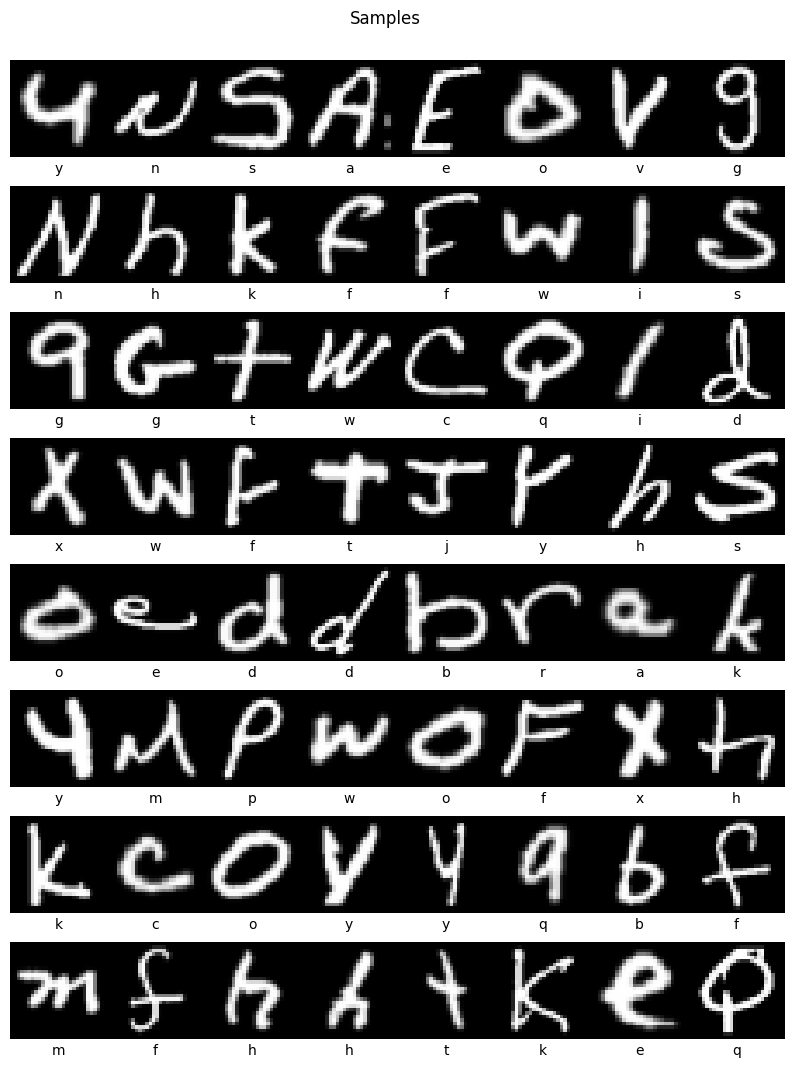

In [4]:
print(type(trainset.images))

BATCH_SIZE = 64
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

features, labels = next(iter(trainloader))
features = features.clone().detach()

visualizeSamples(trainloader, title='Samples')

# Perform PCA and clustering to isolate handwriting "styles"

[18055 24000 26925 19820]


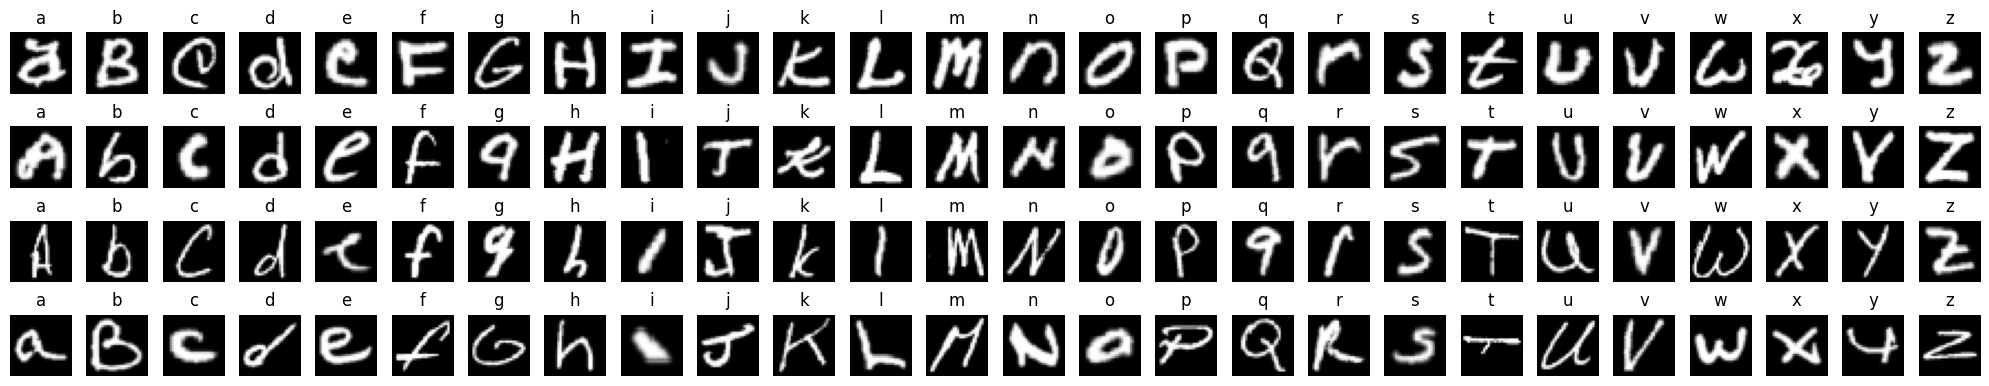

In [5]:
# Flatten the images
flatImages = trainset.images.reshape(len(trainset), -1).numpy()

# Perform PCA
pca = PCA(n_components=500)  # Choose the number of components based on your requirements
PCAFeatures = pca.fit_transform(flatImages)

# Cluster the data points
numClusters = 4  # Choose the number of clusters based on your requirements
kmeans = KMeans(n_clusters=numClusters)
clusterLabels = kmeans.fit_predict(PCAFeatures)


minLettersPerCluster = 1000  # Adjust this value based on your requirements

# Count the number of letters in each cluster
clusterCounts = np.bincount(clusterLabels)
print(clusterCounts)

# Identify clusters with insufficient letters
smallClusters = np.where(clusterCounts < minLettersPerCluster)[0]

# Merge small clusters with the nearest larger clusters
for smallCluster in smallClusters:
    # Find the nearest larger cluster
    nearestCluster = None
    minDistance = float('inf')
    for cluster in range(numClusters):
        if cluster != smallCluster and clusterCounts[cluster] >= minLettersPerCluster:
            distance = np.linalg.norm(kmeans.cluster_centers_[smallCluster] - kmeans.cluster_centers_[cluster])
            if distance < minDistance:
                minDistance = distance
                nearestCluster = cluster
    
    # Merge the small cluster with the nearest larger cluster
    clusterLabels[clusterLabels == smallCluster] = nearestCluster


# Visualize the clusters
fig, axs = plt.subplots(numClusters, 26, figsize=(20, numClusters))
for i in range(numClusters):
    clusterIndices = np.where(clusterLabels == i)[0]
    for j in range(26):
        letterIndices = np.where(trainset.labels[clusterIndices] == j+1)[0]
        if len(letterIndices) > 0:
            imageIndex = clusterIndices[np.random.choice(letterIndices)]
            axs[i, j].imshow(trainset.images[imageIndex].squeeze(), cmap='gray')
            axs[i, j].set_title(trainset.intToStrDict[j+1])
            axs[i, j].axis('off')
        else:
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

# Cluster on individual PCA letters instead of clustering on the entire dataset
### This should let us choose individual letters to include in a handwriting style

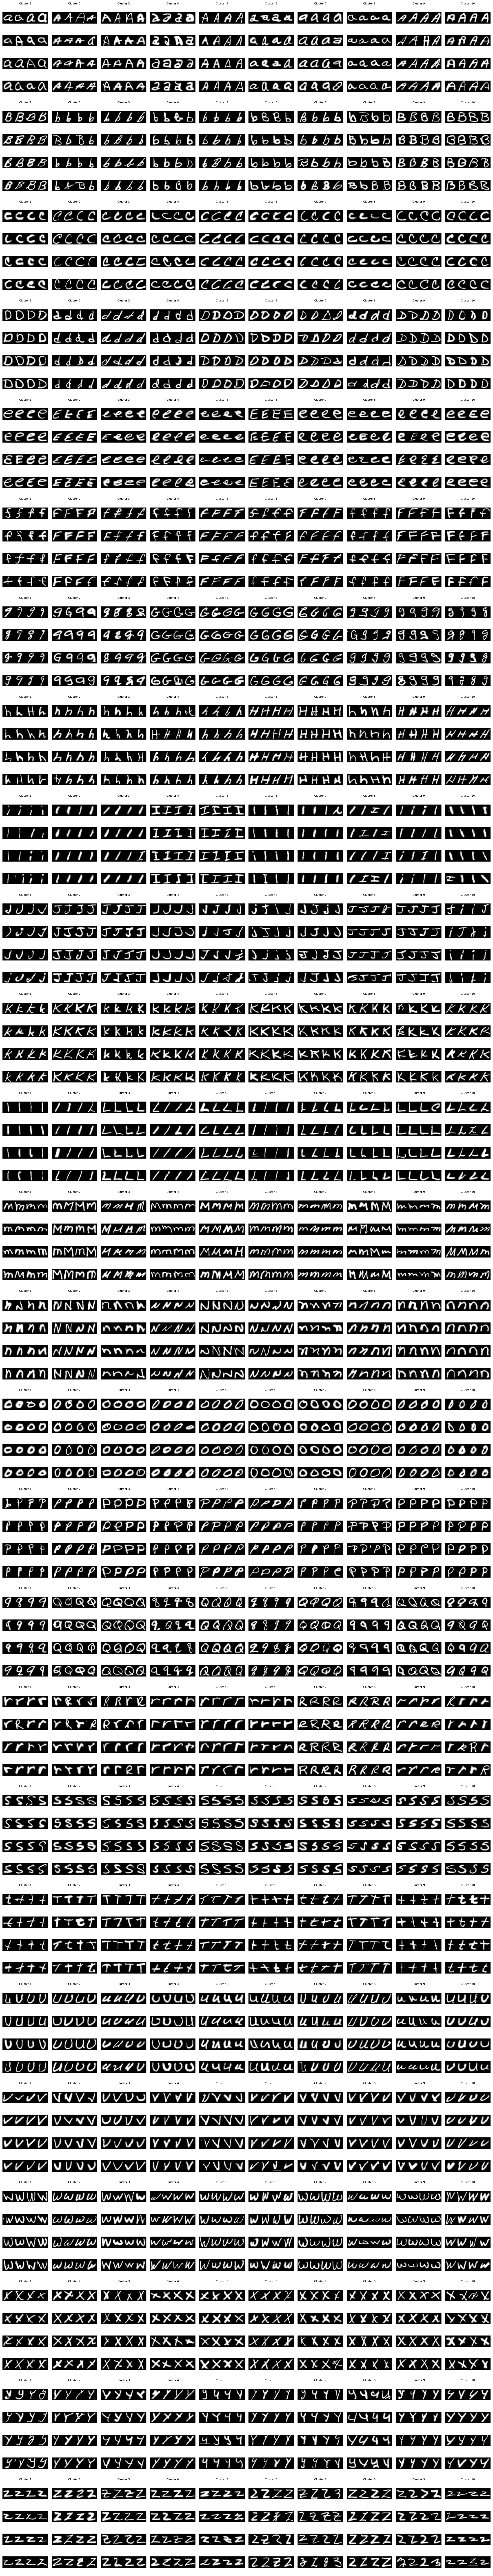

In [10]:
num_clusters = 10  # Choose the number of clusters for each letter
num_samples = 16  # Choose the number of samples to display for each cluster (16 for a 4x4 grid)

width = 2*num_clusters
fig, axs = plt.subplots(26, num_clusters, figsize=(width, 2.6*2*width))
for letter in range(1, 27):
    # Filter images and labels for the current letter
    letter_indices = np.where(trainset.labels == letter)[0]
    letter_images = trainset.images[letter_indices]
    
    # Flatten the images
    flat_images = torch.flatten(letter_images, start_dim=1).numpy()
    
    # Perform PCA
    # pca = PCA(n_components=50)  # Choose the number of components based on your requirements
    # features = pca.fit_transform(flat_images)

    isomap = Isomap(n_components=200, n_jobs=-1, n_neighbors=20)  # Choose the number of components based on your requirements
    features = isomap.fit_transform(flat_images)
    
    # Cluster the data points
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    
    
    # Display samples from each cluster in a 4x4 grid
    for cluster in range(num_clusters):
        cluster_indices = np.where(cluster_labels == cluster)[0]
        cluster_samples = np.random.choice(cluster_indices, size=num_samples, replace=False)
        
        ax = axs[letter-1, cluster]
        ax.axis('off')
        
        for i in range(4):
            for j in range(4):
                sample_idx = cluster_samples[i*4+j]
                image = letter_images[sample_idx].squeeze()
                ax_sub = ax.inset_axes([j*0.25, i*0.25, 0.25, 0.25])
                ax_sub.imshow(image, cmap='gray')
                ax_sub.axis('off')
        
        ax.set_title(f"Cluster {cluster+1}", fontsize=8)

plt.tight_layout()
plt.show()


In [7]:
# TODO: Look at these

'''
https://wandb.ai/capecape/train_sd/reports/How-To-Train-a-Conditional-Diffusion-Model-From-Scratch--VmlldzoyNzIzNTQ1
https://github.com/TeaPearce/Conditional_Diffusion_MNIST
'''

'\nhttps://wandb.ai/capecape/train_sd/reports/How-To-Train-a-Conditional-Diffusion-Model-From-Scratch--VmlldzoyNzIzNTQ1\nhttps://github.com/TeaPearce/Conditional_Diffusion_MNIST\n'

In [1]:
''' 
This script does conditional image generation on MNIST, using a diffusion model

This code is modified from,
https://github.com/cloneofsimo/minDiffusion

Diffusion model is based on DDPM,
https://arxiv.org/abs/2006.11239

The conditioning idea is taken from 'Classifier-Free Diffusion Guidance',
https://arxiv.org/abs/2207.12598

This technique also features in ImageGen 'Photorealistic Text-to-Image Diffusion Modelswith Deep Language Understanding',
https://arxiv.org/abs/2205.11487

'''

from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

# Just a resnet block, nothing special except for it allows for channel increases by skipping the second conv layer
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2 
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

# A UNet block which downsamples by a factor of 2
class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# A UNet block which upsamples by a factor of 2 followed by 2 Residual layers.
# Concatenates skip connections
class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


# A 2 Layer FC network for embedding stuff
class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things  
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


# A UNet composed of UNet blocks that allows for embedding class label and timestep
# during the training process for diffusion
class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()


        self.in_channels = in_channels # Just in_channels which is just 1 since MNIST is grayscale
        self.n_feat = n_feat # Base number of features at the first layer
        self.n_classes = n_classes # Number of classes. Needed for determining how many context embeddings are needed

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU()) # Embed the previous convolutions to a 1D vector

        # The output embedding size is determined by the size of the hidden vector in the latent space.
        self.timeembed1 = EmbedFC(1, 2*n_feat) # Define time embedding layer, takes in the current time and embeds it to a vector
        self.timeembed2 = EmbedFC(1, 1*n_feat) # Define second time layer which produces another time embedding for a later upsampling layer
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat) # Embeds a 1 hot class label to a vector which can be used for conditioning
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat) # Same as previous, but used in a different upsampling layer

        # Upsamples from the smallest latent space to a larger resolution, no conditioning or residuals from UNet
        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat) # Upsample from 4N to N features
        self.up2 = UnetUp(2 * n_feat, n_feat) # Upsample from 2N to N features. This goes from 2N because we concatenate N features from down1
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        ) # Final processing before output

    def forward(self, x, c, t, context_mask):
        # x is (noisy) image, c is context label, t is timestep, 
        # context_mask says which samples to block the context on

        # Encode inputs to latent space
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2) # Create a latent vector representation of our images

        # convert class to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)
        
        # mask out context if context_mask == 1. This is done for classifier free guidance where the model must learn how to generate samples even when
        # not given an explicit class embedding
        context_mask = context_mask[:, None] # Expand dims
        print(f'{context_mask.shape=}')
        context_mask = context_mask.repeat(1,self.n_classes) 
        context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
        c = c * context_mask
        
        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        print(f'{c.shape=}')
        print(f'{cemb1.shape=}')
        print(f'{t.shape=}')
        print(f'{temb1.shape=}')
        print(f'{self.contextembed1(c).shape=}')
        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        # Perform upsampling on latent space guided by class and time embeddings.
        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1)) # TODO: Why concatenate here?
        return out


def ddpm_schedules(startBeta: float, endBeta: float, T: int):
    
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    
    startBeta: How much noise there should be at the start of the noising process on a scale from 0-1 (very little)
    endBeta: How much noise there should be at the end of the noising process on a scale from 0-1 (near 1)
    T: Total number of timesteps in the diffusion process
    """
    
    assert startBeta < endBeta < 1.0, "startBeta and endBeta must be in (0, 1)"

    # Noising (forward) process:
    # Noised Image at time T = x_t
    # x_t = sqrt(1-beta_t)x_{t-1} + sqrt(beta_t) N(0, I)
    # alpha_t = 1-beta_t
    # x_t = sqrt(alpha_t)x_{t-1} + sqrt(beta_t) N(0, I)

    beta_t = (endBeta - startBeta) * torch.arange(0, T + 1, dtype=torch.float32) / T + startBeta
    # beta_t = torch.linspace(startBeta, endBeta, T) # Linearly interpolate betas for all timesteps
    sqrt_beta_t = torch.sqrt(beta_t) # sqrt of beta is what is used in the diffusion process
    alpha_t = 1 - beta_t # The compliment to beta
    log_alpha_t = torch.log(alpha_t) # Take the log of alphas so we can easily calculate the product over all alphas for each time
    
    # This is how much noise we want to remove at each timestep
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp() # Since we are using log alpha, we can calculate the product by log summation and exponentiation

    sqrtab = torch.sqrt(alphabar_t) # sqrt alphabar is what is used in the diffusion formula
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }


class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, x, c):
        """
        this method is used in training, so samples t and noise randomly
        """

        _ts = torch.randint(1, self.n_T+1, (x.shape[0],)).to(self.device)  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * noise
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        # dropout context with some probability
        context_mask = torch.bernoulli(torch.zeros_like(c)+self.drop_prob).to(self.device)
        
        # return MSE between added noise, and our predicted noise
        return self.loss_mse(noise, self.nn_model(x_t, c, _ts / self.n_T, context_mask))

    def sample(self, n_sample, size, device, guide_w = 0.0):
        # we follow the guidance sampling scheme described in 'Classifier-Free Diffusion Guidance'
        # to make the fwd passes efficient, we concat two versions of the dataset,
        # one with context_mask=0 and the other context_mask=1
        # we then mix the outputs with the guidance scale, w
        # where w>0 means more guidance

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0,10).to(device) # context for us just cycles throught the mnist labels
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))

        # don't drop context at test time
        context_mask = torch.zeros_like(c_i).to(device)

        # double the batch
        c_i = c_i.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[n_sample:] = 1. # makes second half of batch context free

        x_i_store = [] # keep track of generated steps in case want to plot something 
        print()
        for i in range(self.n_T, 0, -1):
            print(f'sampling timestep {i}',end='\r')
            t_is = torch.tensor([i / self.n_T]).to(device)
            t_is = t_is.repeat(n_sample,1,1,1)

            # double batch
            x_i = x_i.repeat(2,1,1,1)
            t_is = t_is.repeat(2,1,1,1)

            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0

            # split predictions and compute weighting
            eps = self.nn_model(x_i, c_i, t_is, context_mask)
            eps1 = eps[:n_sample]
            eps2 = eps[n_sample:]
            eps = (1+guide_w)*eps1 - guide_w*eps2
            x_i = x_i[:n_sample]
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )
            if i%20==0 or i==self.n_T or i<8:
                x_i_store.append(x_i.detach().cpu().numpy())
        
        x_i_store = np.array(x_i_store)
        return x_i, x_i_store


def train_mnist():

    # hardcoding these here
    n_epoch = 20
    batch_size = 128
    n_T = 400 # 500
    device = "cuda:0"
    n_classes = 10
    n_feat = 88 # 128 ok, 256 better (but slower)
    lrate = 1e-4
    save_model = False
    save_dir = './DiffusionData/'
    ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

    ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes), betas=(1e-4, 0.02), n_T=n_T, device=device, drop_prob=0.1)
    ddpm.to(device)

    # optionally load a model
    # ddpm.load_state_dict(torch.load("./data/diffusion_outputs/ddpm_unet01_mnist_9.pth"))

    tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

    dataset = MNIST("./data", train=True, download=True, transform=tf)
    # dataset = trainset
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

    for ep in range(n_epoch):
        print(f'epoch {ep}')
        ddpm.train()

        # linear lrate decay
        optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

        pbar = tqdm(dataloader)
        for x, c in pbar:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            loss = ddpm(x, c)
            loss.backward()

            pbar.set_description(f"loss: {loss.item():.4f}")
            optim.step()
        
        # for eval, save an image of currently generated samples (top rows)
        # followed by real images (bottom rows)
        ddpm.eval()
        with torch.no_grad():
            n_sample = 4*n_classes
            for w_i, w in enumerate(ws_test):
                x_gen, x_gen_store = ddpm.sample(n_sample, (1, 28, 28), device, guide_w=w)

                # append some real images at bottom, order by class also
                x_real = torch.Tensor(x_gen.shape).to(device)
                for k in range(n_classes):
                    for j in range(int(n_sample/n_classes)):
                        try: 
                            idx = torch.squeeze((c == k).nonzero())[j]
                        except:
                            idx = 0
                        x_real[k+(j*n_classes)] = x[idx]

                x_all = torch.cat([x_gen, x_real])
                grid = make_grid(x_all*-1 + 1, nrow=10)
                save_image(grid, save_dir + f"image_ep{ep}_w{w}.png")
                print('saved image at ' + save_dir + f"image_ep{ep}_w{w}.png")

                if ep%5==0 or ep == int(n_epoch-1):
                    # create gif of images evolving over time, based on x_gen_store
                    fig, axs = plt.subplots(nrows=int(n_sample/n_classes), ncols=n_classes,sharex=True,sharey=True,figsize=(8,3))
                    def animate_diff(i, x_gen_store):
                        print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
                        plots = []
                        for row in range(int(n_sample/n_classes)):
                            for col in range(n_classes):
                                axs[row, col].clear()
                                axs[row, col].set_xticks([])
                                axs[row, col].set_yticks([])
                                # plots.append(axs[row, col].imshow(x_gen_store[i,(row*n_classes)+col,0],cmap='gray'))
                                plots.append(axs[row, col].imshow(-x_gen_store[i,(row*n_classes)+col,0],cmap='gray',vmin=(-x_gen_store[i]).min(), vmax=(-x_gen_store[i]).max()))
                        return plots
                    ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store],  interval=200, blit=False, repeat=True, frames=x_gen_store.shape[0])    
                    ani.save(save_dir + f"gif_ep{ep}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
                    print('saved image at ' + save_dir + f"gif_ep{ep}_w{w}.gif")
        # optionally save model
        if save_model and ep == int(n_epoch-1):
            torch.save(ddpm.state_dict(), save_dir + f"model_{ep}.pth")
            print('saved model at ' + save_dir + f"model_{ep}.pth")

if __name__ == "__main__":
    torch.cuda.empty_cache()
    train_mnist()

epoch 0


  0%|          | 0/469 [00:00<?, ?it/s]

context_mask.shape=torch.Size([128, 1])
c.shape=torch.Size([128, 10])
cemb1.shape=torch.Size([128, 176, 1, 1])
t.shape=torch.Size([128])
temb1.shape=torch.Size([128, 176, 1, 1])
self.contextembed1(c).shape=torch.Size([128, 176])


loss: 0.4849:   1%|          | 4/469 [00:00<00:59,  7.79it/s]

context_mask.shape=torch.Size([128, 1])
c.shape=torch.Size([128, 10])
cemb1.shape=torch.Size([128, 176, 1, 1])
t.shape=torch.Size([128])
temb1.shape=torch.Size([128, 176, 1, 1])
self.contextembed1(c).shape=torch.Size([128, 176])
context_mask.shape=torch.Size([128, 1])
c.shape=torch.Size([128, 10])
cemb1.shape=torch.Size([128, 176, 1, 1])
t.shape=torch.Size([128])
temb1.shape=torch.Size([128, 176, 1, 1])
self.contextembed1(c).shape=torch.Size([128, 176])
context_mask.shape=torch.Size([128, 1])
c.shape=torch.Size([128, 10])
cemb1.shape=torch.Size([128, 176, 1, 1])
t.shape=torch.Size([128])
temb1.shape=torch.Size([128, 176, 1, 1])
self.contextembed1(c).shape=torch.Size([128, 176])
context_mask.shape=torch.Size([128, 1])
c.shape=torch.Size([128, 10])
cemb1.shape=torch.Size([128, 176, 1, 1])
t.shape=torch.Size([128])
temb1.shape=torch.Size([128, 176, 1, 1])
self.contextembed1(c).shape=torch.Size([128, 176])
context_mask.shape=torch.Size([128, 1])
c.shape=torch.Size([128, 10])
cemb1.shape=to

loss: 0.2735:   2%|▏         | 10/469 [00:00<00:30, 15.30it/s]

context_mask.shape=torch.Size([128, 1])
c.shape=torch.Size([128, 10])
cemb1.shape=torch.Size([128, 176, 1, 1])
t.shape=torch.Size([128])
temb1.shape=torch.Size([128, 176, 1, 1])
self.contextembed1(c).shape=torch.Size([128, 176])
context_mask.shape=torch.Size([128, 1])
c.shape=torch.Size([128, 10])
cemb1.shape=torch.Size([128, 176, 1, 1])
t.shape=torch.Size([128])
temb1.shape=torch.Size([128, 176, 1, 1])
self.contextembed1(c).shape=torch.Size([128, 176])
context_mask.shape=torch.Size([128, 1])
c.shape=torch.Size([128, 10])
cemb1.shape=torch.Size([128, 176, 1, 1])
t.shape=torch.Size([128])
temb1.shape=torch.Size([128, 176, 1, 1])
self.contextembed1(c).shape=torch.Size([128, 176])
context_mask.shape=torch.Size([128, 1])
c.shape=torch.Size([128, 10])
cemb1.shape=torch.Size([128, 176, 1, 1])
t.shape=torch.Size([128])
temb1.shape=torch.Size([128, 176, 1, 1])
self.contextembed1(c).shape=torch.Size([128, 176])
context_mask.shape=torch.Size([128, 1])
c.shape=torch.Size([128, 10])
cemb1.shape=to

loss: 0.1771:   3%|▎         | 15/469 [00:01<00:33, 13.45it/s]

context_mask.shape=torch.Size([128, 1])
c.shape=torch.Size([128, 10])
cemb1.shape=torch.Size([128, 176, 1, 1])
t.shape=torch.Size([128])
temb1.shape=torch.Size([128, 176, 1, 1])
self.contextembed1(c).shape=torch.Size([128, 176])
context_mask.shape=torch.Size([128, 1])
c.shape=torch.Size([128, 10])
cemb1.shape=torch.Size([128, 176, 1, 1])
t.shape=torch.Size([128])
temb1.shape=torch.Size([128, 176, 1, 1])
self.contextembed1(c).shape=torch.Size([128, 176])
context_mask.shape=torch.Size([128, 1])
c.shape=torch.Size([128, 10])
cemb1.shape=torch.Size([128, 176, 1, 1])
t.shape=torch.Size([128])
temb1.shape=torch.Size([128, 176, 1, 1])
self.contextembed1(c).shape=torch.Size([128, 176])
context_mask.shape=torch.Size([128, 1])
c.shape=torch.Size([128, 10])
cemb1.shape=torch.Size([128, 176, 1, 1])
t.shape=torch.Size([128])
temb1.shape=torch.Size([128, 176, 1, 1])
self.contextembed1(c).shape=torch.Size([128, 176])
context_mask.shape=torch.Size([128, 1])
c.shape=torch.Size([128, 10])
cemb1.shape=to

KeyboardInterrupt: 